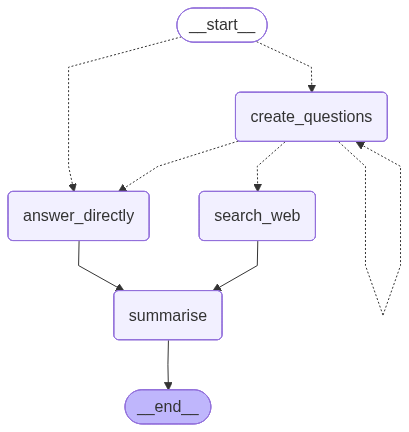

In [1]:
from pprint import pprint

from nodes import create_questions, should_continue, search_web, answer_directly, summarise, should_break_query
from state import Question
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display


# Add nodes and edges


builder = StateGraph(state_schema=Question)
builder.add_node("create_questions", create_questions)
builder.add_node("answer_directly", answer_directly)
builder.add_node("search_web", search_web)
builder.add_node("summarise", summarise)

builder.add_conditional_edges(START, should_break_query, ["answer_directly", "create_questions"])
builder.add_conditional_edges("create_questions", should_continue, ["create_questions", "search_web", "answer_directly"])
builder.add_edge("search_web", "summarise")
builder.add_edge("answer_directly", "summarise")
builder.add_edge("summarise", END)

# Compile
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [2]:
thread = {"configurable": {"thread_id":"1"}}
graph.invoke(
    {"query":"What's the difference between LangSmith and LangGraph?"},
    thread
)

should_break_query returned: 'create_questions'
Router decision: search_web


{'messages': [AIMessage(content="Breaking down the query into sub-questions: ['What are the key differences between LangSmith and LangGraph in terms of their primary functions and use cases?', 'How do LangSmith and LangGraph differ in their approach to language model development and workflow management?']", additional_kwargs={}, response_metadata={}, id='fe1510a1-1c90-4e04-80b3-cbc10c93c1c2', tool_calls=[], invalid_tool_calls=[]),
  AIMessage(content='Searched web for 2 sub-questions: What are the key differences between LangSmith and LangGraph in terms of their primary functions and use cases?, How do LangSmith and LangGraph differ in their approach to language model development and workflow management?', additional_kwargs={}, response_metadata={}, id='2e4ed83d-a461-48c2-a68b-b7c47aeb4372', tool_calls=[], invalid_tool_calls=[]),
  AIMessage(content='**Direct Answer to the Query:**  \nLangSmith and LangGraph serve distinct roles in the LangChain ecosystem. **LangGraph** is focused on o

In [3]:
state = graph.get_state(thread)
print("Generated questions:", state.values.get("questions"))

Generated questions: ['What are the key differences between LangSmith and LangGraph in terms of their primary functions and use cases?', 'How do LangSmith and LangGraph differ in their approach to language model development and workflow management?']


In [4]:
for key, value in state.values.items():
    print(f"{key}: {value}")
    print("------")

messages: [AIMessage(content="Breaking down the query into sub-questions: ['What are the key differences between LangSmith and LangGraph in terms of their primary functions and use cases?', 'How do LangSmith and LangGraph differ in their approach to language model development and workflow management?']", additional_kwargs={}, response_metadata={}, id='fe1510a1-1c90-4e04-80b3-cbc10c93c1c2', tool_calls=[], invalid_tool_calls=[]), AIMessage(content='Searched web for 2 sub-questions: What are the key differences between LangSmith and LangGraph in terms of their primary functions and use cases?, How do LangSmith and LangGraph differ in their approach to language model development and workflow management?', additional_kwargs={}, response_metadata={}, id='2e4ed83d-a461-48c2-a68b-b7c47aeb4372', tool_calls=[], invalid_tool_calls=[]), AIMessage(content='**Direct Answer to the Query:**  \nLangSmith and LangGraph serve distinct roles in the LangChain ecosystem. **LangGraph** is focused on orchestr

In [5]:
state.values.get("summary").pretty_print()

================================== Ai Message ==================================

**Direct Answer to the Query:**  
LangSmith and LangGraph serve distinct roles in the LangChain ecosystem. **LangGraph** is focused on orchestrating complex, stateful workflows and multi-agent interactions, while **LangSmith** provides observability, debugging, and monitoring capabilities for LLM applications in production.  

---

### **Supporting Details and Evidence**  

1. **Primary Functions:**  
   - **LangGraph** is a state machine and workflow engine designed to manage complex, multi-agent workflows with loops, conditions, and state management. It allows dynamic routing and branching logic, making it ideal for resilient, long-running applications [1].  
     - Example: "LangGraph handles complex workflows that require loops, conditions, and state management" [2].  
   - **LangSmith** is a platform for tracing, debugging, and evaluating LLM workflows. It integrates with LangChain and LangGraph to p